In [1]:
import pandas as pd #Для работы с таблицами данных (дата фреймы)
import requests #Для запросов к серверу
import json #Для обработки ответов сервера
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import apimoex
import requests
import yfinance as yf

In [2]:
def get_company_data(names, start_date, end_date):
    try:
        data = pd.read_csv('D:/Jupyter notebook/files/НИР/all_shares_better.csv', index_col=0, parse_dates=True)
    except FileNotFoundError:
        print("File not found!")
        return None

    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    
    selected_names = list(filter(lambda x: x in data.columns, names))

    if not selected_names:
        print("No data found for the specified company names!")
        return None
    
    # Select the rows corresponding to the specified company names and date range
    company_data = data.loc[(data.index >= start_date) & (data.index <= end_date), selected_names]
    
    # Return the selected data as a new DataFrame
    return pd.DataFrame(company_data)

In [3]:
def get_company_data(names, start_date, end_date):
    data = pd.read_csv('D:/Jupyter notebook/files/НИР/all_shares.csv', index_col=0, parse_dates=True)
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    # Filter out names that are not in the data
    valid_names = [name for name in names if name in data.columns]

    # Select the rows corresponding to the valid company names and date range
    company_data = data.loc[(data.index >= start_date) & (data.index <= end_date), valid_names]

    # Return the selected data as a new DataFrame
    return pd.DataFrame(company_data)


In [3]:
#функция, чтобы считать доходность и волатильность портфеля за определенный период
def portfolio_metrics(df, start_date, end_date, weights):
    # select the rows for the specified period
    df_period = df.loc[start_date:end_date]

    # calculate the daily returns
    daily_returns = df_period.pct_change()

    # calculate the portfolio returns
    portfolio_returns = (daily_returns * weights).sum(axis=1)

    # calculate the annualized return
    annual_return = (1 + portfolio_returns.mean()) ** 252 - 1

    # calculate the annualized volatility
    annual_volatility = np.sqrt(252) * portfolio_returns.std()

    # calculate the Sharpe ratio
    risk_free_rate = 0.03 # assuming a risk-free rate of 3%
    sharpe_ratio = (annual_return - risk_free_rate) / annual_volatility

    return annual_return, annual_volatility, sharpe_ratio

In [4]:
import pandas as pd
import numpy as np
from datetime import datetime


def portfolio_metrics(df, start_date, end_date, weights):
    """
    Computes the annualized return, annualized volatility, and Sharpe ratio for a given portfolio of assets.

    Parameters:
    - df: pandas DataFrame containing the asset prices.
    - start_date: string in the format 'YYYY-MM-DD' representing the start date of the historical data.
    - end_date: string in the format 'YYYY-MM-DD' representing the end date of the historical data.
    - weights: pandas Series containing the weights of each asset in the portfolio.

    Returns:
    - annual_return: float representing the annualized return of the portfolio.
    - annual_volatility: float representing the annualized volatility of the portfolio.
    - sharpe_ratio: float representing the Sharpe ratio of the portfolio.
    """

    # Select the relevant subset of the DataFrame based on the start and end dates
    df = df.loc[start_date:end_date]

    # Compute the daily returns of the assets
    #returns = df.pct_change().dropna()
    returns = df.pct_change()

    # Compute the portfolio's daily returns
    portfolio_returns = (weights * returns).sum(axis=1)

    # Compute the annualized return of the portfolio
    total_return = (1 + portfolio_returns).prod()
    n_years = (datetime.strptime(end_date, '%Y-%m-%d') - datetime.strptime(start_date, '%Y-%m-%d')).days / 365
    annual_return = (total_return ** (1 / n_years)) - 1

    # Compute the annualized volatility of the portfolio
    annual_volatility = np.sqrt(252) * portfolio_returns.std()

    # Compute the Sharpe ratio of the portfolio
    sharpe_ratio = np.sqrt(252) * (annual_return / annual_volatility)

    return annual_return, annual_volatility, sharpe_ratio


In [5]:
import numpy as np
import pandas as pd
import arch

def portfolio_metrics_arch(df, start_date, end_date, weights):
    # select the rows for the specified period
    df_period = df.loc[start_date:end_date]

    # calculate the daily returns
    daily_returns = df_period.pct_change()

    # calculate the portfolio returns
    portfolio_returns = (daily_returns * weights).sum(axis=1)

    # estimate the volatility using a GARCH(1,1) model
    model = arch.arch_model(portfolio_returns, mean='Zero', vol='GARCH', p=1, q=1)
    results = model.fit(disp='off')
    annual_volatility = np.sqrt(252) * results.conditional_volatility[-1]

    # calculate the annualized return
    annual_return = (1 + portfolio_returns.mean()) ** 252 - 1

    # calculate the Sharpe ratio
    risk_free_rate = 0.03 # assuming a risk-free rate of 3%
    sharpe_ratio = (annual_return - risk_free_rate) / annual_volatility

    return annual_return, annual_volatility, sharpe_ratio

In [6]:
def finding_weights(companies, start, end):
    df_intermediate  = get_company_data(companies, start, end)
    
    #df_intermediate = df_intermediate.dropna( thresh = 0.5*len(df_intermediate.index) , axis='columns') #выкидывает колонки, где пропущенные значения больше 80%
    df_intermediate.fillna(method='ffill', inplace=True)
    
    column_names = df_intermediate.columns.tolist()
    log_returns = np.log(df_intermediate).diff()
    # calculate the volatility for each share
    volatility = log_returns.std()
    weights = volatility.rank().apply(lambda x: 1/x)
    weights /= weights.sum()
    return(column_names, weights)


In [7]:
def getting_retur_volat(companies, weights, start, end):
    df= get_company_data(companies, start, end)
    # Find the column with the least number of NaNs
    n_nans = df.isna().sum()
    min_n_nans = n_nans.min()
    col_to_drop = n_nans[n_nans > min_n_nans].index.tolist()

    # Drop columns with more NaNs than the minimum
    df = df.drop(columns=col_to_drop)

    # Drop rows with NaNs in the remaining columns
    df = df.dropna(axis=0)


    #df_new = df_new.dropna( thresh = 0.5*len(df_new.index) , axis='columns') #выкидывает колонки, где пропущенные значения больше 80%
    #df_new.fillna(method='ffill', inplace=True)
    metrics = portfolio_metrics(df,  start_date= start, end_date = end, weights = weights[1])
    return(metrics)

In [8]:
#Get a 14 lists of a companies
n = 14 #years 
for i in range(n):
    filename = f"D:/Jupyter notebook/files/НИР/список акций/список акций на { i+2009}.xlsx"
    cap = pd.read_excel(filename)
    globals()[f"companies_{i+2009}"] = list(cap['Торговый код'])

In [9]:
companies_2014

['LKOH',
 'MSNG',
 'RTKM',
 'TATN',
 'SBER',
 'OGKE',
 'HYDR',
 'MSRS',
 'MTLR',
 'TRMK',
 'TGKA',
 'NVTK',
 'MTSS',
 'MGNT',
 'LSRG',
 'URKA',
 'PIKK',
 'IRAO',
 'NMOS',
 'UTAR',
 'MRKP',
 'GCHE',
 'ALRS',
 'MRKC',
 'VTBR',
 'PHOR',
 'MOEX',
 'VZRZ',
 'AFLT',
 'DIXY',
 'RGSS',
 'VTGK',
 'KMAZ',
 'NKNC',
 'MRKZ',
 'GMKN',
 'MRKU',
 'MRKV',
 'SELG',
 'TGKD',
 'IRGZ',
 'MVID',
 'GAZP',
 'SVAV',
 'ARMD',
 'VSMO',
 'CHMF',
 'GRAZ',
 'ROSB',
 'MAGN',
 'NLMK',
 'RASP',
 'TGKE',
 'TGKF',
 'ROSN',
 'MSSB',
 'TGKB',
 'HALS',
 'EONR',
 'TGKN',
 'BSPB',
 'AVAZ',
 'LSNG',
 'AKRN',
 'TGKI',
 'AFKS',
 'NMTP',
 'CHZN',
 'DVEC',
 'FEES',
 'MRKS',
 'APTK',
 'VRAO',
 'FESH',
 'SYNG',
 'MRKY',
 'RSEA',
 'MSTT',
 'KBTK',
 'TAER',
 'TRCN',
 'OPIN',
 'PRTK',
 'ROST',
 'RBCM',
 'PHST',
 'WTCM',
 'VRPH',
 'SNGS',
 'GAZC',
 'GAZS',
 'GAZT',
 'OGKB',
 'MFON',
 'RSTI',
 'AMEZ',
 'SEMZ',
 'ZHIV',
 'MGVM',
 'AVAN',
 'WBDF',
 'ZMZN',
 'YRSL',
 'MMBM',
 'KRSG',
 'KROT',
 'KUBE',
 'MFGS',
 'GUMM',
 'TZUM',
 'PRMB',
 

In [10]:
df_weighted = pd.DataFrame(columns=['return', 'volatility'])
for i in range(13):
    globals()[f"information_{i+2009}_{(i+1)+2009}"] = finding_weights(companies=globals()[f"companies_{i+2009}"], start=f"{i+2009}-01-01", end=f"{(i+1)+2009}-01-01")
    #print(globals()[f"information_{i+2009}_{(i+1)+2009}"])
    globals()[f"retur_vol_{(i+1)+2009}_{(i+2)+2009}"] = getting_retur_volat(globals()[f"information_{i+2009}_{(i+1)+2009}"][0],
                                                                            weights=globals()[f"information_{i+2009}_{(i+1)+2009}"][1], 
                                                                            start=f"{(i+1)+2009}-01-01", end=f"{(i+2)+2009}-01-01")
    #print(globals()[f"retur_vol_{(i+1)+2009}_{(i+2)+2009}"])
    df_weighted.loc[f"{2009+i+1}_{2009+i+2}"] = [globals()[f"retur_vol_{(i+1)+2009}_{(i+2)+2009}"][0],
                                                 globals()[f"retur_vol_{(i+1)+2009}_{(i+2)+2009}"][1]]


In [11]:
df_weighted

,return,volatility
2010_2011,0.430236,0.124904
2011_2012,-0.077273,0.056546
2012_2013,-0.013148,0.179311
2013_2014,-0.030809,0.042964
2014_2015,0.007614,0.043097
2015_2016,0.249782,0.073982
2016_2017,0.132417,0.030863
2017_2018,0.040164,0.047954
2018_2019,0.047587,0.237500
2019_2020,0.254336,0.068792


In [12]:
# calculate the weights for each year
years = [int(y) for y in df_weighted.index.str.split('_').str[0]]
weights = [y2 - y1 for y1, y2 in zip(years[:-1], years[1:])]
weights.append(weights[-1])

# calculate the weighted average of the return and volatility
weighted_return = np.average(df_weighted['return'], weights=weights)
weighted_volatility = np.average(df_weighted['volatility'], weights=weights)

print("Weighted average return:", weighted_return)
print("Weighted average volatility:", weighted_volatility)

Weighted average return: 0.12459875239264484
Weighted average volatility: 0.09271439355882082


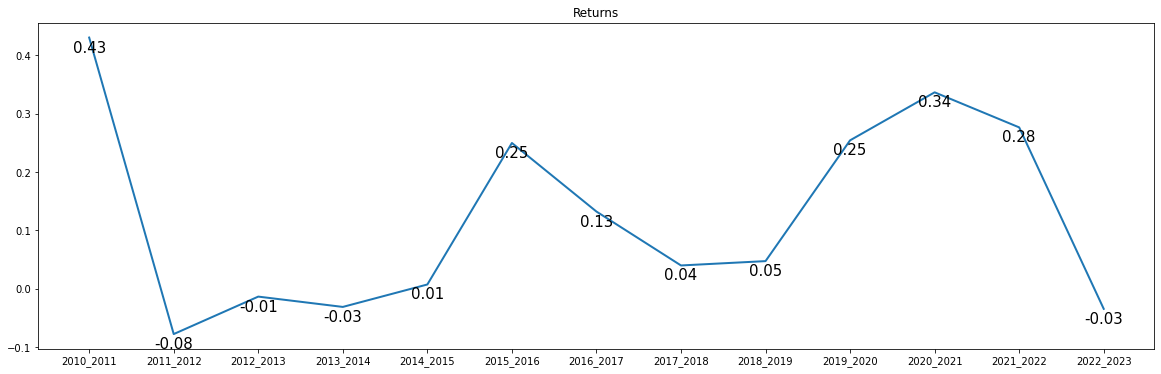

In [13]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(df_weighted.index, df_weighted['return'], linewidth=2.0)
for i, y in enumerate(df_weighted['return']):
    #ax.scatter(df_weighted.index, df_weighted['return'], s=10, c='red', marker='o')
    ax.text(df_weighted.index[i], y - 0.03, f'{y:.2f}', ha='center', va='bottom', fontsize=15)
ax.set_title('Returns')
plt.savefig('returns_weighted_2010-2023.jpg', bbox_inches='tight', dpi = 100)
plt.show()

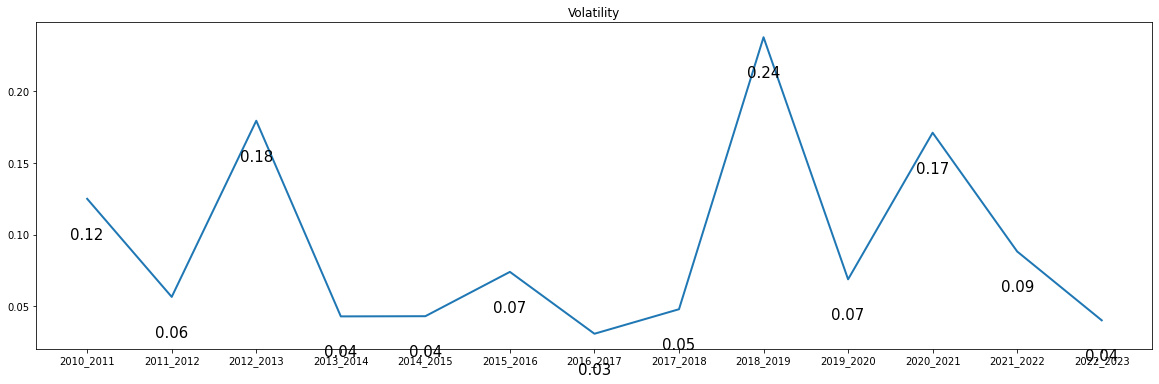

In [14]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(df_weighted.index, df_weighted['volatility'], linewidth=2.0)
for i, y in enumerate(df_weighted['volatility']):
    #ax.scatter(df_weighted.index, df_weighted['return'], s=10, c='red', marker='o')
    ax.text(df_weighted.index[i], y - 0.03, f'{y:.2f}', ha='center', va='bottom', fontsize=15)
ax.set_title('Volatility')
plt.savefig('volatility_weighted_2010-2023.jpg', bbox_inches='tight', dpi = 100)
plt.show()

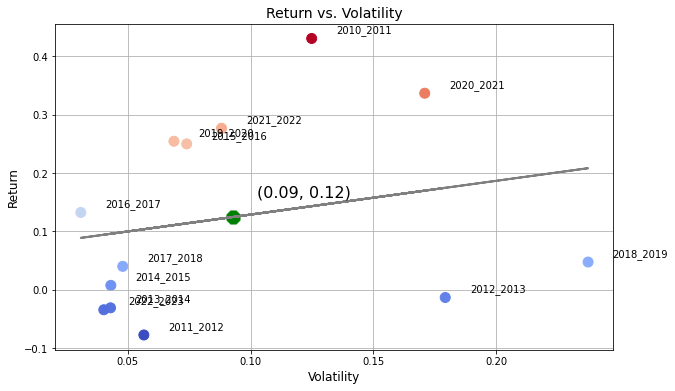

Weighted average return: 0.12459875239264484
Weighted average volatility: 0.09271439355882082


In [15]:
# Create scatter plot with text annotations and trend line
fig, ax = plt.subplots(figsize=(10, 6))
im = ax.scatter(df_weighted['volatility'], df_weighted['return'], s=100, c=df_weighted['return'], cmap='coolwarm')
ax.scatter( weighted_volatility,weighted_return, color = 'green',marker = '8', s = 200)
for i, year_range in enumerate(df_weighted.index):
    ax.text(df_weighted['volatility'][i] + 0.01, df_weighted['return'][i] + 0.01, year_range, fontsize=10)
z = np.polyfit(df_weighted['volatility'], df_weighted['return'], 1)
p = np.poly1d(z)
ax.plot(df_weighted['volatility'], p(df_weighted['volatility']), "-", color='gray', linewidth=2)

# Set labels and title
ax.set_xlabel('Volatility', fontsize=12)
ax.set_ylabel('Return', fontsize=12)
ax.set_title('Return vs. Volatility', fontsize=14)

ax.annotate((weighted_volatility.round(2),weighted_return.round(2)), (weighted_volatility+ 0.01, weighted_return+0.03),
            horizontalalignment='left',
            fontsize=16,
            verticalalignment='bottom')

# Add colorbar
#fig.colorbar(im, ax=ax)

# Add grid
ax.grid()
plt.savefig('ret vs vol weighted.jpg', bbox_inches='tight', dpi = 100)
plt.show()
print("Weighted average return:", weighted_return)
print("Weighted average volatility:", weighted_volatility)

### Что очень интересно, так это то, что года распределись поровну снизу и сверху. С чем это может быть связано? Лишь с тем, что стратегия неэффективна

In [16]:
df = globals()[f"information_{0+2009}_{(0+1)+2009}"][1]

In [18]:
df.values

array([0.0218241 , 0.00264534, 0.00759099, 0.0012744 , 0.01343021,
       0.00218241, 0.0032942 , 0.00623546, 0.00107773, 0.00387984,
       0.0072747 , 0.00335755, 0.00831394, 0.01745928, 0.00212918,
       0.01247091, 0.00155886, 0.00872964, 0.00425836, 0.0096996 ,
       0.0145494 , 0.00513508, 0.00371474, 0.0040603 , 0.00529069,
       0.0064664 , 0.02494182, 0.00128377, 0.00277131, 0.00133277,
       0.00109807, 0.00189775, 0.00286218, 0.01587207, 0.00110502,
       0.00171169, 0.00317441, 0.00235936, 0.00581976, 0.00793603,
       0.00215547, 0.00105176, 0.00459455, 0.00226744, 0.01163952,
       0.00918909, 0.00268604, 0.00223837, 0.01027016, 0.00349186,
       0.01091205, 0.00137475, 0.00103924, 0.00301022, 0.00103309,
       0.00105814, 0.00102702, 0.00114113, 0.00106459, 0.00149225,
       0.0019186 , 0.00193992, 0.00253033, 0.00205403, 0.00563202,
       0.00198401, 0.00187734,        nan, 0.0024249 , 0.00174593,
       0.08729638, 0.00160177, 0.00498836, 0.00245905, 0.00108

In [27]:
df[1]

ALRS    0.003062
VTBR    0.003429
RUAL    0.002091
ENPG    0.003297
AFLT    0.005913
          ...   
ISKJ    0.000922
GEMA    0.003648
UNAC    0.001824
LIFE    0.000942
NAUK    0.002143
Length: 206, dtype: float64

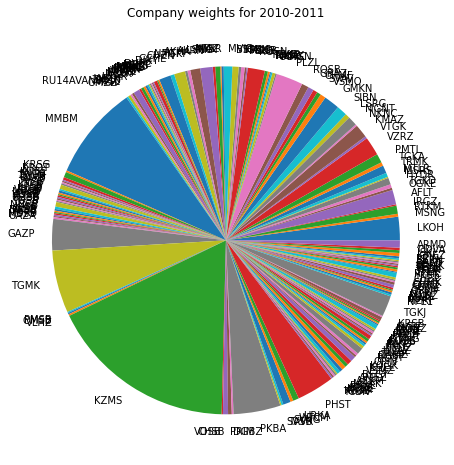

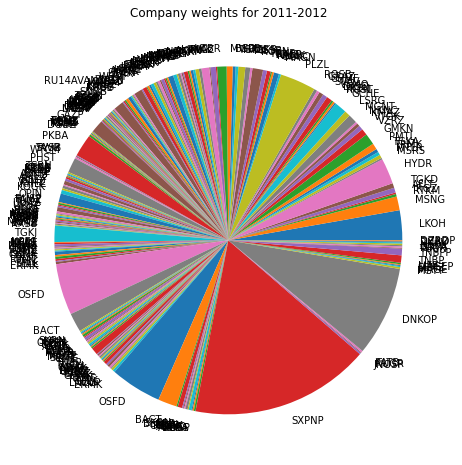

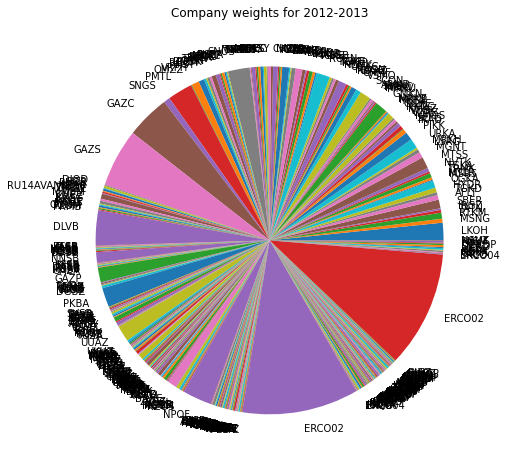

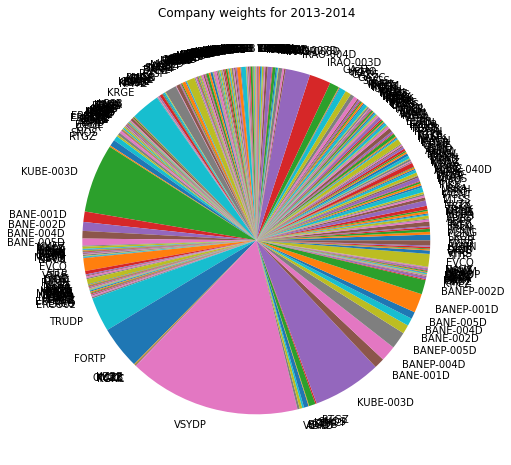

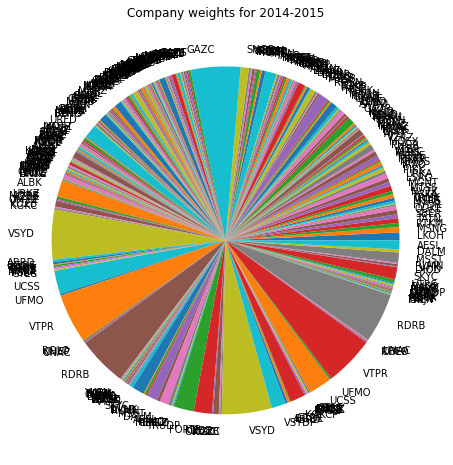

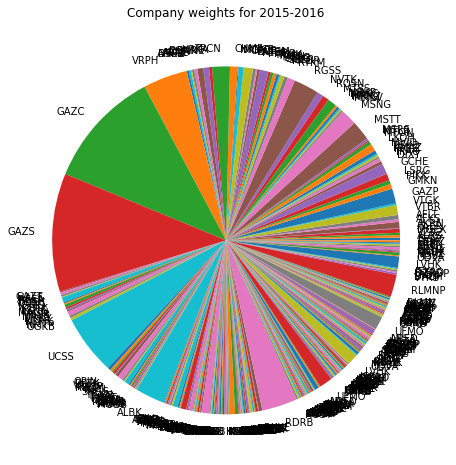

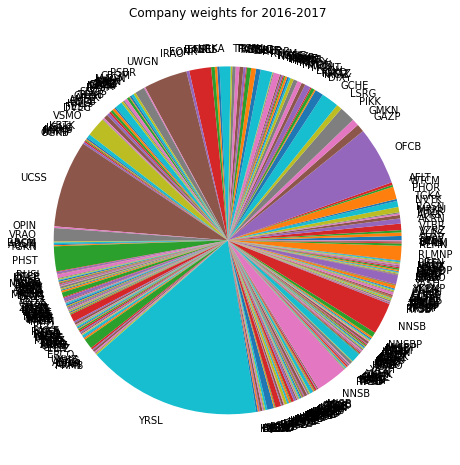

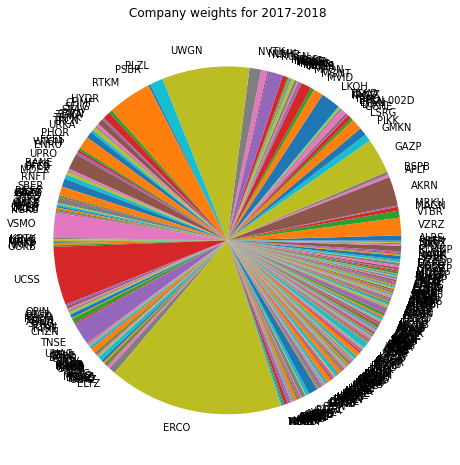

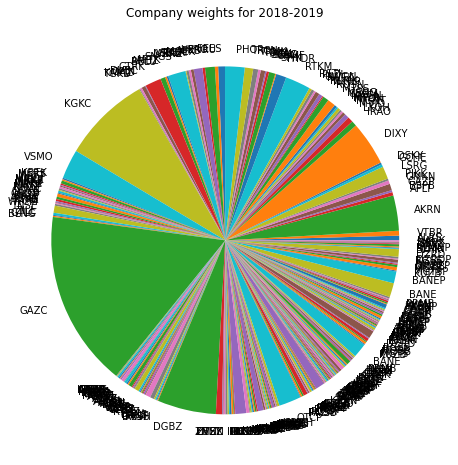

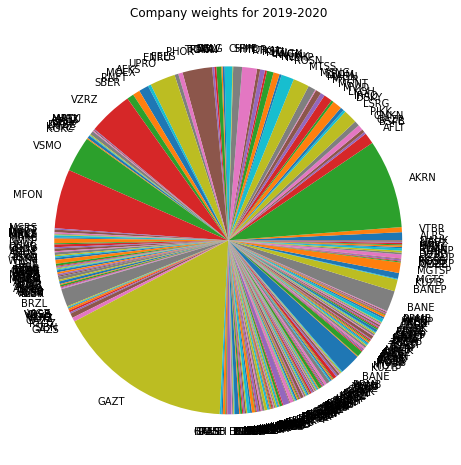

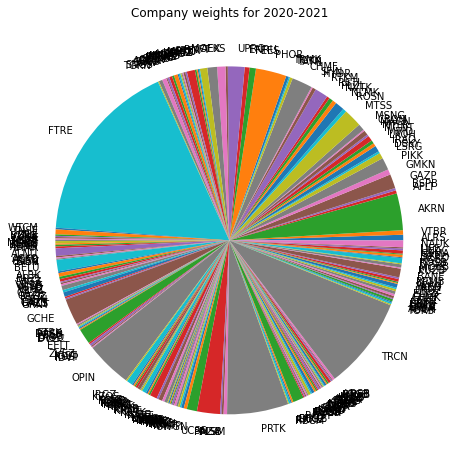

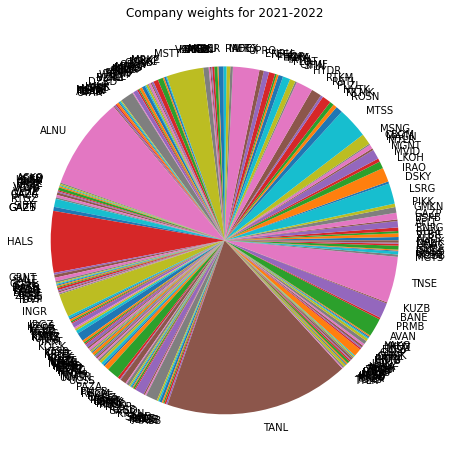

In [24]:
for i in range(1, 13):
    df = globals()[f"information_{i+2009}_{(i+1)+2009}"][1]
    df = df.fillna(0) # fill NaN values with 0
    plt.figure(figsize=(8, 8))
    plt.pie(df.values, labels=df.index)
    plt.title(f'Company weights for {i+2009}-{(i+1)+2009}')
    plt.show()
